## Structured Multi-Class Classification with StructureBoost
Often, in multi-class classification problems, the classes in the target variable
possess a *structure* that would be helpful to exploit.

In this notebook, we illustrate how to use StructureBoost to exploit structure
in the target variable of multiclass classification problems.

In this particular example, we will consider a problem where the month of the year is 
the target variable.  The months of the year naturally possess a circular structure as January
is "next to" December in the same way that June is "next to" July.  We will show how exploiting
this structure yields better predictions.  At the same time, we will learn how to configure and
use StructureBoost to exploit the structure in categorical target variables.


## Imports, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
df_ca = pd.read_csv('data/ca_weather.csv')

## Load the Data and Explore
As you can see below, this is a dataset where each row represents the weather observations from a particular weather station on a particular date.  We know the min and max temperature (TMIN, TMAX), the amount of precipitation (PRCP), as well as the month of the observation and the county where the weather station is located.

California has 58 counties, however, the weather station in Sutter County does not record temperature, so for the purposes of this exercise we are combining Sutter and Yuba counties into a single county "Sutter_Yuba" so that there are 57 counties.  You can see below that we have selected 5000 observations from each of the 57 counties.

In [3]:
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285000 entries, 0 to 284999
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   county   285000 non-null  object 
 1   month    285000 non-null  int64  
 2   PRCP     285000 non-null  float64
 3   TMAX     285000 non-null  float64
 4   TMIN     285000 non-null  float64
 5   DATE     285000 non-null  object 
 6   STATION  285000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 15.2+ MB


In [4]:
df_ca.sample(5)

,county,month,PRCP,TMAX,TMIN,DATE,STATION
111164,Mendocino,6,0.75,65.0,57.0,2013-06-25,USC00043161
197996,San_Luis_Obispo,10,0.00,63.0,52.0,2003-10-03,USC00045866
168174,Sacramento,3,0.00,72.0,43.0,2000-03-22,USW00093225
76470,Kings,6,0.00,86.0,58.0,2015-06-03,USC00044534
238401,Solano,10,0.00,80.0,48.0,2001-10-24,USC00042934


In [5]:
df_ca.county.value_counts()

Alameda            5000
Orange             5000
Plumas             5000
Riverside          5000
Sacramento         5000
San_Benito         5000
San_Bernardino     5000
San_Diego          5000
San_Francisco      5000
San_Joaquin        5000
San_Luis_Obispo    5000
San_Mateo          5000
Santa_Barbara      5000
Santa_Clara        5000
Santa_Cruz         5000
Shasta             5000
Sierra             5000
Siskiyou           5000
Solano             5000
Sonoma             5000
Stanislaus         5000
Tehama             5000
Trinity            5000
Tulare             5000
Tuolumne           5000
Ventura            5000
Yolo               5000
Placer             5000
Nevada             5000
Alpine             5000
Napa               5000
Amador             5000
Butte              5000
Calaveras          5000
Colusa             5000
Contra_Costa       5000
Del_Norte          5000
El_Dorado          5000
Fresno             5000
Glenn              5000
Humboldt           5000
Imperial        

In [6]:
df_ca.month.value_counts()

5     24772
3     24648
1     24610
7     24416
8     24031
4     23688
10    23673
6     23324
12    23317
9     23063
2     22778
11    22680
Name: month, dtype: int64

## Goal
First, we are going to build a model that tries to predict the month of the year, given the min and max temperature (TMIN, TMAX) and the amount of precipitation (PRCP).  In general, we don't expect to be able to predict the month exactly, but we would like to have an accurate probability distribution on what month it is given the temperatures and precipitation that day.  Thus we will use the `log_loss` to determine the quality of our predictions.

Clearly, there is some meaningful *structure* in the target variable month.  We expect the weather in January to be more similar to December than it is to July.  Thus, it is reasonable to expect that we will get better performance if the model is aware of these similarities during training, rather than just knowing that months are different from one another.


In [7]:
np.unique(df_ca.month)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

As would be expected, the months are numbered 1 through 12.  StructureBoost requires the target to be integers from 0 to num_classes-1.  Thus, we will create a modified "month" variable where December (12) is designated as 0.

In [8]:
tvec = df_ca['month'].copy()
tvec[tvec==12] = 0
df_ca['month_mod'] = tvec

In [9]:
np.unique(df_ca.month_mod)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Now we'll split the data into training, validation, and test_folds

In [10]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [11]:
# Here we can configure the sizes of our training, validation and test sets (and the rest will be a "remainder")
train_size = 1000
valid_size = 5000
test_size = 100000

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, X_rem.shape


((1000, 3), (5000, 3), (100000, 3), (179000, 3))

## Configuring StructureBoost Target Structure

StructureBoost permits two methods for defining the structure on a target variable:

    1. Using a fixed set of partitions (with corresponding weights)
    2. Using a graph, and randomly choosing partitions from the graph.

The idea is that the partitions provide meaningful "coarsenings" of the target state space.  The loss function, will then be able to take into account that values in the same *block* of the partition are similar.  The beauty of this approach is that we can use many partitions at the same time.

For example, for the months of the year, one might consider that the months of each season tend to have similar weather.  This might lead us to define a partition of the months such as:
{Dec, Jan, Feb}, {Mar, Apr, May}, {Jun, Jul, Aug}, {Sep, Oct, Nov}

In [12]:
# This is a quick way to get a starting feature configuration that can be modified
fc1 = stb.get_basic_config(X_train, stb.default_config_dict())
fc1

{'TMAX': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'TMIN': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'PRCP': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

First we will run StructureBoost with no knowledge of the structure of the months.

In [13]:
# Define the StructureBoost model and fit it
stb0 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=None, learning_rate=.02)
stb0.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.3890038754134517
i=20, eval_set_loss = 2.323317356598625
i=30, eval_set_loss = 2.2766458411224644
i=40, eval_set_loss = 2.2435759007115665
i=50, eval_set_loss = 2.220499934628192
i=60, eval_set_loss = 2.20478900215626
i=70, eval_set_loss = 2.19149489202869
i=80, eval_set_loss = 2.1822316812467584
i=90, eval_set_loss = 2.1757846814964723
i=100, eval_set_loss = 2.1714983091914455
i=110, eval_set_loss = 2.168198086385436
i=120, eval_set_loss = 2.1661761488721445
i=130, eval_set_loss = 2.1645733555859317
i=140, eval_set_loss = 2.1639437785504327
i=150, eval_set_loss = 2.1637088338188217
i=160, eval_set_loss = 2.1633924944548113
i=170, eval_set_loss = 2.1631352069258067
i=180, eval_set_loss = 2.163841534032274
Stopping early: curr_loss of 2.163841534032274
                                        exceeds compare_loss of 2.1631352069258067


In [14]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_0 = stb0.predict_proba(X_test)
log_loss(y_test, test_preds_0)

2.1546700363650797

Next, we will configure StructureBoost using a fixed set of partitions.  We will group the months in "blocks" of size 3 - and there are 3 different partitions, depending on where we start grouping.

StructureBoost assumes you will always use the singleton partition as part of the partition set.  We give a weight using the `singleton_weight` parameter.

The weights for the other partitions in the partition set must be designated by the `partition_weight_vec` parameter.  The weights should sum to 1.  (you will get a warning, but not an error, if this is not the case).

In the example below, the singleton partition has weight 0.4 and the other 3 partitions each have weight 0.2.

In [15]:
# Here we configure the target structure to use a fixed, weighted partition
ts1 = {}
ts1['partition_type'] = 'fixed'
ts1['singleton_weight'] = .4
ts1['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                         [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                         [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
ts1['partition_weight_vec'] = [.2,.2,.2]

In [16]:
# Define the StructureBoost model and fit it
stb1 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts1, learning_rate=.02)

stb1.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.3978186756273803
i=20, eval_set_loss = 2.3328466771006706
i=30, eval_set_loss = 2.2853950804675973
i=40, eval_set_loss = 2.2508550213121996
i=50, eval_set_loss = 2.225397902189174
i=60, eval_set_loss = 2.2062610301482977
i=70, eval_set_loss = 2.1916442943952608
i=80, eval_set_loss = 2.1810994840433024
i=90, eval_set_loss = 2.1737560893538186
i=100, eval_set_loss = 2.167654810243412
i=110, eval_set_loss = 2.1633841174600517
i=120, eval_set_loss = 2.160973207520432
i=130, eval_set_loss = 2.158068223949387
i=140, eval_set_loss = 2.156355853269231
i=150, eval_set_loss = 2.155437440473987
i=160, eval_set_loss = 2.154206251313224
i=170, eval_set_loss = 2.154014085756576
i=180, eval_set_loss = 2.1539950403781005
i=190, eval_set_loss = 2.1546558292411584
Stopping early: curr_loss of 2.1546558292411584
                                        exceeds compare_loss of 2.1539950403781005


In [17]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_1 = stb1.predict_proba(X_test)
log_loss(y_test, test_preds_1)

2.1456820054584016

In some cases it may be tedious to write out a fixed partition.  There is an alternative, when the desired structure can be represented in terms of a *graph*.  In this case we can simply provide the graph and ask StructureBoost to randomly find partitions of the graph (which respect the structure of the graph).  Then, at each iteration, a different, randomly chosen partition (or partitions) of the graph will be used, in conjunction with the singleton partition.

We show how to configure this below.

In [18]:
# First we must define the appropriate graph
cycle_0_11 = stb.graphs.cycle_int_graph(0,11)
cycle_0_11.vertices, cycle_0_11.edges

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {frozenset({3, 4}),
  frozenset({2, 3}),
  frozenset({9, 10}),
  frozenset({1, 2}),
  frozenset({4, 5}),
  frozenset({0, 1}),
  frozenset({6, 7}),
  frozenset({8, 9}),
  frozenset({7, 8}),
  frozenset({5, 6}),
  frozenset({0, 11}),
  frozenset({10, 11})})

In [19]:
# Here we configure the target structure to use a variable (random) partition
# We must specify how many partitions we want, and of what sizes
# Note: partition size refers to the *number* of blocks, not the size of the blocks

ts2a = {}
ts2a['partition_type'] = 'variable'
ts2a['target_graph'] = cycle_0_11
ts2a['singleton_weight'] = .5
ts2a['num_partitions'] = 1
ts2a['random_partition_size'] = 4

In [20]:
stb2a = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2a, learning_rate=.02)

stb2a.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.3965954009907424
i=20, eval_set_loss = 2.3344199985192082
i=30, eval_set_loss = 2.2878050931268468
i=40, eval_set_loss = 2.25297656652924
i=50, eval_set_loss = 2.2277720960113054
i=60, eval_set_loss = 2.209395686274858
i=70, eval_set_loss = 2.1954311916390035
i=80, eval_set_loss = 2.1849393990460877
i=90, eval_set_loss = 2.1778675885342387
i=100, eval_set_loss = 2.1717430719766524
i=110, eval_set_loss = 2.1674721151531977
i=120, eval_set_loss = 2.1633440976573084
i=130, eval_set_loss = 2.161875960612751
i=140, eval_set_loss = 2.160639320269018
i=150, eval_set_loss = 2.159234626445285
i=160, eval_set_loss = 2.1595098994151902
Stopping early: curr_loss of 2.1595098994151902
                                        exceeds compare_loss of 2.159234626445285


In [21]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2a = stb2a.predict_proba(X_test)
log_loss(y_test, test_preds_2a)

2.150674329278085

In [22]:
# This time, let's configure it so that there are multiple partitions, of various sizes
# Each partition is given the same weight (= (1-singleton_weight)/num_partitions))
ts2b = {}
ts2b['partition_type'] = 'variable'
ts2b['target_graph'] = cycle_0_11
ts2b['singleton_weight'] = .5
ts2b['num_partitions'] = 5
ts2b['random_partition_size'] = [3,3,4,5,6]

In [23]:
stb2b = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2b, learning_rate=.02)

stb2b.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.396458793349196
i=20, eval_set_loss = 2.3312907691941027
i=30, eval_set_loss = 2.283036590151717
i=40, eval_set_loss = 2.2491768534939016
i=50, eval_set_loss = 2.2238551601987813
i=60, eval_set_loss = 2.205904129490063
i=70, eval_set_loss = 2.192107713685235
i=80, eval_set_loss = 2.182162356618174
i=90, eval_set_loss = 2.1746971686891166
i=100, eval_set_loss = 2.1691963748380467
i=110, eval_set_loss = 2.165860844140398
i=120, eval_set_loss = 2.1622678875807337
i=130, eval_set_loss = 2.160766194167346
i=140, eval_set_loss = 2.159267706123605
i=150, eval_set_loss = 2.158557564284738
i=160, eval_set_loss = 2.15831444017402
i=170, eval_set_loss = 2.158333727175485
Stopping early: curr_loss of 2.158333727175485
                                        exceeds compare_loss of 2.15831444017402


In [24]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2b = stb2b.predict_proba(X_test)
log_loss(y_test, test_preds_2b)

2.149831148755294

## Rigorous testing, Varying the singleton weight
Let's see how this does as we vary the singleton weight from 0.0 to 1.0: Note that a singleton weight of 0 is not recommended, as it means there is no "incentive" to get the month exactly right.  A singleton weight of 1 means that we are not using the structure at all - it is equivalent to setting `target_structure=None` (using a classical approach to multi-classification).

In [25]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [26]:
train_size = 5000
valid_size = 5000
test_size = 100000
num_trials= 5
sw_vec = np.arange(0,11)/10

ll_mat = np.zeros((num_trials, len(sw_vec)))
acc_mat = np.zeros((num_trials, len(sw_vec)))


for tr in range(num_trials):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42+tr)
    X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42+tr)
    X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42+tr)




    for i,sw in enumerate(sw_vec):
        print('Singleton weight = {}'.format(sw))
        print('trial_number = {}'.format(tr))
        ts = {}
        ts['partition_type'] = 'fixed'
        ts['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                                 [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                                 [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
        ts['singleton_weight'] = sw
        rem = (1-sw)/3
        ts['partition_weight_vec'] = [rem, rem, rem]
        stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)
        stb_tmp.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)
        preds_tmp = stb_tmp.predict_proba(X_test)
        ll = log_loss(y_test, preds_tmp)
        hard_preds = np.argmax(preds_tmp,axis=1)
        acc = accuracy_score(y_test,hard_preds)
        ll_mat[tr,i] = ll
        acc_mat[tr,i] = acc

Singleton weight = 0.0
trial_number = 0
i=0, eval_set_loss = 2.486296015703045
i=10, eval_set_loss = 2.415176770073439
i=20, eval_set_loss = 2.3578473540455858
i=30, eval_set_loss = 2.3123976890688493
i=40, eval_set_loss = 2.2759465617232943
i=50, eval_set_loss = 2.2474893306097723
i=60, eval_set_loss = 2.225137735726465
i=70, eval_set_loss = 2.207375948467844
i=80, eval_set_loss = 2.193418027034909
i=90, eval_set_loss = 2.182258010863218
i=100, eval_set_loss = 2.173398201887031
i=110, eval_set_loss = 2.1661417608121387
i=120, eval_set_loss = 2.159795701640702
i=130, eval_set_loss = 2.154718273967978
i=140, eval_set_loss = 2.1503951113069246
i=150, eval_set_loss = 2.1467510708196844
i=160, eval_set_loss = 2.1434403202648915
i=170, eval_set_loss = 2.140542122801839
i=180, eval_set_loss = 2.138322923669194
i=190, eval_set_loss = 2.1361226352309064
i=200, eval_set_loss = 2.1345774357931173
i=210, eval_set_loss = 2.132713737182532
i=220, eval_set_loss = 2.1312968128083463
i=230, eval_set_l

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_82660/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.381349579346789
i=20, eval_set_loss = 2.3116154440067644
i=30, eval_set_loss = 2.262397893147696
i=40, eval_set_loss = 2.227438659889133
i=50, eval_set_loss = 2.2017649228952534
i=60, eval_set_loss = 2.1823093685224464
i=70, eval_set_loss = 2.1679979429586753
i=80, eval_set_loss = 2.1573428988357533
i=90, eval_set_loss = 2.1490666725380962
i=100, eval_set_loss = 2.1423325622871285
i=110, eval_set_loss = 2.1374150738910846
i=120, eval_set_loss = 2.1328810735217987
i=130, eval_set_loss = 2.129850427081602
i=140, eval_set_loss = 2.1274340036646833
i=150, eval_set_loss = 2.1255181851787217
i=160, eval_set_loss = 2.1238135348849667
i=170, eval_set_loss = 2.1226928925222417
i=180, eval_set_loss = 2.1217642470789766
i=190, eval_set_loss = 2.121011582479947
i=200, eval_set_loss = 2.120392200206913
i=210, eval_set_loss = 2.1199720653388616
i=220, eval_set_loss = 2.1196994316589763
i=230, eval_set_loss = 2.119501419420041
i=240, eval_set_loss = 2.11916470603138
i=250, eva

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_82660/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.378470231941189
i=20, eval_set_loss = 2.3062468042108106
i=30, eval_set_loss = 2.255241907098227
i=40, eval_set_loss = 2.218955364003044
i=50, eval_set_loss = 2.1923308181777976
i=60, eval_set_loss = 2.1727727215470556
i=70, eval_set_loss = 2.1581694204554647
i=80, eval_set_loss = 2.1466766522997998
i=90, eval_set_loss = 2.137652559665121
i=100, eval_set_loss = 2.1311234261401624
i=110, eval_set_loss = 2.1259454653883694
i=120, eval_set_loss = 2.1218804834906906
i=130, eval_set_loss = 2.118578566762812
i=140, eval_set_loss = 2.1158772043388803
i=150, eval_set_loss = 2.11387640852773
i=160, eval_set_loss = 2.112588461003851
i=170, eval_set_loss = 2.1113113888367283
i=180, eval_set_loss = 2.110713815035515
i=190, eval_set_loss = 2.110158336559455
i=200, eval_set_loss = 2.109398815566253
i=210, eval_set_loss = 2.1092370267175182
i=220, eval_set_loss = 2.1089055103126695
i=230, eval_set_loss = 2.108782814155562
i=240, eval_set_loss = 2.1083027352131016
i=250, eval_s

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_82660/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.3820163585124567
i=20, eval_set_loss = 2.31233678410732
i=30, eval_set_loss = 2.2633397650827787
i=40, eval_set_loss = 2.2280150749502434
i=50, eval_set_loss = 2.2032165517417996
i=60, eval_set_loss = 2.1839960559294376
i=70, eval_set_loss = 2.169329910388428
i=80, eval_set_loss = 2.1582922634779655
i=90, eval_set_loss = 2.1500861278589007
i=100, eval_set_loss = 2.143629007247423
i=110, eval_set_loss = 2.138886656825894
i=120, eval_set_loss = 2.1350408109248415
i=130, eval_set_loss = 2.1318282669966213
i=140, eval_set_loss = 2.1289951061756747
i=150, eval_set_loss = 2.1268938262844523
i=160, eval_set_loss = 2.1249771335074783
i=170, eval_set_loss = 2.123620296173273
i=180, eval_set_loss = 2.1227897172175063
i=190, eval_set_loss = 2.1220601898870695
i=200, eval_set_loss = 2.121454742533411
i=210, eval_set_loss = 2.1208624272105037
i=220, eval_set_loss = 2.1207392310218833
i=230, eval_set_loss = 2.1204743259744805
i=240, eval_set_loss = 2.1203319128120657
i=250, e

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_82660/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.372943767692012
i=20, eval_set_loss = 2.2997357410561863
i=30, eval_set_loss = 2.2490935999390036
i=40, eval_set_loss = 2.212502232379623
i=50, eval_set_loss = 2.18652383781707
i=60, eval_set_loss = 2.166924545647258
i=70, eval_set_loss = 2.1525073906162104
i=80, eval_set_loss = 2.1415504637978984
i=90, eval_set_loss = 2.132948219218874
i=100, eval_set_loss = 2.1262665550001882
i=110, eval_set_loss = 2.1217093653096466
i=120, eval_set_loss = 2.1177013046914896
i=130, eval_set_loss = 2.1148757196743695
i=140, eval_set_loss = 2.112755070852387
i=150, eval_set_loss = 2.111025586515689
i=160, eval_set_loss = 2.1096687459008883
i=170, eval_set_loss = 2.108935524479766
i=180, eval_set_loss = 2.108031807005726
i=190, eval_set_loss = 2.107477758973104
i=200, eval_set_loss = 2.107435751688352
i=210, eval_set_loss = 2.1067811147254782
i=220, eval_set_loss = 2.1063922952683014
i=230, eval_set_loss = 2.106260357279508
i=240, eval_set_loss = 2.1060633254995675
i=250, eval_se

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_82660/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.375280633216756
i=20, eval_set_loss = 2.3016812823378694
i=30, eval_set_loss = 2.2502105844976223
i=40, eval_set_loss = 2.2130657061591346
i=50, eval_set_loss = 2.1864803829659993
i=60, eval_set_loss = 2.1658047742802395
i=70, eval_set_loss = 2.1504254228405917
i=80, eval_set_loss = 2.138382045744707
i=90, eval_set_loss = 2.129398450393715
i=100, eval_set_loss = 2.1224452298020173
i=110, eval_set_loss = 2.1169946094439203
i=120, eval_set_loss = 2.1126860726918104
i=130, eval_set_loss = 2.109058922920128
i=140, eval_set_loss = 2.106166304836134
i=150, eval_set_loss = 2.103798639549706
i=160, eval_set_loss = 2.10175843222378
i=170, eval_set_loss = 2.099886270496961
i=180, eval_set_loss = 2.0984339473186284
i=190, eval_set_loss = 2.0976852166803455
i=200, eval_set_loss = 2.096900373581503
i=210, eval_set_loss = 2.095943995066124
i=220, eval_set_loss = 2.095773261591132
i=230, eval_set_loss = 2.09547370117006
i=240, eval_set_loss = 2.094816464137233
i=250, eval_set_

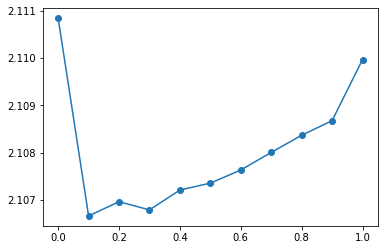

In [27]:
ll_vec = np.mean(ll_mat, axis=0)
plt.plot(sw_vec, ll_vec, marker='o')

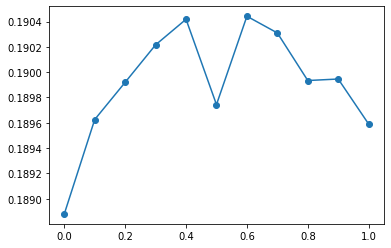

In [28]:
acc_vec = np.mean(acc_mat, axis=0)
plt.plot(sw_vec, acc_vec, marker='o')